In [3]:
import numpy as np
from sage.plot.ellipse import Ellipse

def EFG(X, u, v):
    X_u = X.diff(u)
    X_v = X.diff(v)
    E(u, v) = X_u.dot_product(X_u)
    F(u, v) = X_u.dot_product(X_v)
    G(u, v) = X_v.dot_product(X_v)
    return (E, F, G)


def metric(X, u, v):
    E, F, G = EFG(X, u, v)
    def g(x, y): return matrix([[E(x, y), F(x, y)], [F(x, y), G(x, y)]])
    return g


def sample_metric(g, urange=(-1, 1), vrange=(-1, 1), ucount=5, vcount=5, sq_len=0.2):
    squares = []
    transformed_squares = []

    uspace = np.linspace(urange[0], urange[1], ucount)
    vspace = np.linspace(vrange[0], vrange[1], vcount)
    space = cartesian_product_iterator([uspace, vspace])
    for u, v in space:
        square = matrix([[-sq_len/2, -sq_len/2, sq_len/2, sq_len/2], [-sq_len/2, sq_len/2, sq_len/2, -sq_len/2]])
        translate = matrix([[u, u, u, u], [v, v, v, v]])
        transformed = g(u, v) * square
        
        squares.append(square + translate)
        transformed_squares.append(transformed + translate)

    return squares, transformed_squares

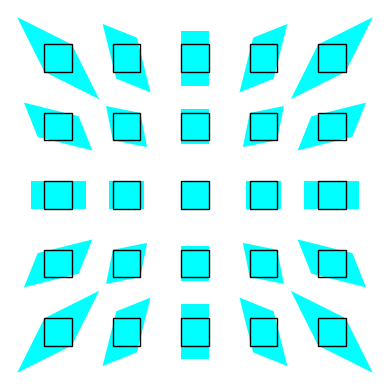

In [4]:
# X(theta, phi) = (cos(theta)*sin(phi),sin(theta)*sin(phi),cos(phi))
# g = metric(X, theta, phi)

X(u, v) = (u, v, (u^2 + v^2)/2)
# X(u, v) = (u, v, 1/(u^2 + v^2 + 1))
g = metric(X, u, v)
squares, transformed_squares = sample_metric(g)

plot = Graphics()
plot += sum([polygon([(x, y) for x, y in transformed.transpose()], color='cyan', axes=False) for transformed in transformed_squares])
plot += sum([polygon([(x, y) for x, y in square.transpose()], fill=False, color='black', axes=False) for square in squares])
show(plot)

In [5]:
def sample_metric_eigenvals(g, urange=(-1, 1), vrange=(-1, 1), ucount=5, vcount=5, sq_len=0.2):
    def angle(a, b):
        return arccos(a.inner_product(b) / (a.norm() * b.norm())) if a.norm() * b.norm() != 0 else 0
    
    squares = []
    transformed_squares = []
    ellipses = []

    uspace = np.linspace(urange[0], urange[1], ucount)
    vspace = np.linspace(vrange[0], vrange[1], vcount)
    space = cartesian_product_iterator([uspace, vspace])
    for u, v in space:
        g_curr = g(u, v)
        eigenvectors = g_curr.eigenvectors_right()
        eigvec = eigenvectors[0][1][0]
        k1 = eigenvectors[0][0]
        if eigenvectors[0][2] == 2:
            k2 = k1
        else:
            k2 = eigenvectors[1][0]
        
        square = matrix([[0, -sq_len/2, 0, sq_len/2], [-sq_len/2, 0, sq_len/2, 0]])
        cross = vector([eigvec[0], eigvec[1], 0]).cross_product(vector([1, 0, 0]))
        theta = arctan2(cross[2], eigvec.dot_product(vector([1, 0])))
        R = matrix([[cos(theta), sin(theta)], [-sin(theta), cos(theta)]])
        
        translate = matrix([[u, u, u, u], [v, v, v, v]])
        transformed = g_curr * R * square
        
        squares.append((R * square) + translate)
        transformed_squares.append(transformed + translate)
        ellipses.append((u, v, abs(k1*sq_len/2), abs(k2*sq_len/2), -theta))

    return squares, transformed_squares, ellipses

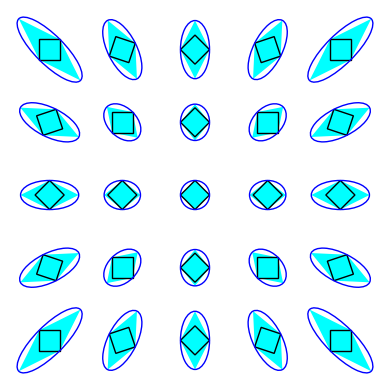

In [6]:
# X(theta, phi) = (cos(theta)*sin(phi),sin(theta)*sin(phi),cos(phi))
# g = metric(X, theta, phi)

X(u, v) = (u, v, (u^2 + v^2)/2)
# X(u, v) = (u, v, 1/(u^2 + v^2 + 1))
g = metric(X, u, v)
squares, transformed_squares, ellipses = sample_metric_eigenvals(g)

plot = Graphics()
plot += sum([polygon([(x, y) for x, y in transformed.transpose()], color='cyan', axes=False) for transformed in transformed_squares])
plot += sum([polygon([(x, y) for x, y in square.transpose()], fill=False, color='black', axes=False) for square in squares])
plot += sum([ellipse((x, y), k1, k2, theta) for x, y, k1, k2, theta in ellipses])
show(plot)

Animation with 10 frames
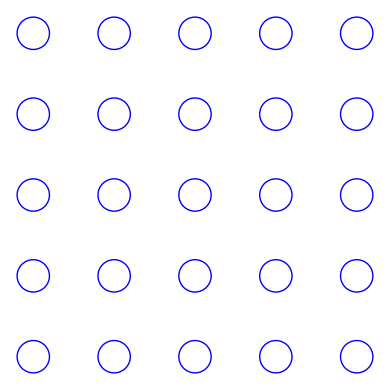

In [64]:
X(u, v, a) = (u, v, a^2*(u^2 + v^2)/2)


plots = []
for a in np.linspace(0, 1.5, 10):
    g = metric(X(u, v, a), u, v)
    squares, transformed_squares, ellipses = sample_metric_eigenvals(g)
    
    plot = Graphics()
#     plot += sum([polygon([(x, y) for x, y in transformed.transpose()], color='cyan', axes=False) for transformed in transformed_squares])
#     plot += sum([polygon([(x, y) for x, y in square.transpose()], fill=False, color='black', axes=False) for square in squares])
    plot += sum([ellipse((x, y), k1, k2, theta, axes=False) for x, y, k1, k2, theta in ellipses])
    plots.append(plot)
    
animate(plots)

In [53]:
def christoffel(u, v, E, F, G, as_dict=False):
    E_u = diff(E, u)
    E_v = diff(E, v)
    F_u = diff(F, u)
    F_v = diff(F, v)
    G_u = diff(G, u)
    G_v = diff(G, v)
    
    C111 = var('C111')
    C121 = var('C121')
    C221 = var('C221')
    C112 = var('C112')
    C122 = var('C122')
    C222 = var('C222')
    
    eqn_11 = C111 * E + C112 * F == 1/2 * E_u
    eqn_12 = C111 * F + C112 * G == F_u - 1/2 * E_v
    
    eqn_21 = C121 * E + C122 * F == 1/2 * E_v
    eqn_22 = C121 * F + C122 * G == 1/2 * G_u
    
    eqn_31 = C221 * E + C222 * F == F_v - 1/2 * G_u
    eqn_32 = C221 * F + C222 * G == 1/2 * G_v
    
    C_sol_1 = solve([eqn_11, eqn_12], C111, C112)
    C_sol_2 = solve([eqn_21, eqn_22], C121, C122)
    C_sol_3 = solve([eqn_31, eqn_32], C221, C222)
    
    # We substitute the solutions for the Christoffel symbols into the Cijk to be returned.
    C111 = C111.subs(C_sol_1[0])
    C112 = C112.subs(C_sol_1[0])
    C121 = C121.subs(C_sol_2[0])
    C122 = C122.subs(C_sol_2[0])
    C221 = C221.subs(C_sol_3[0])
    C222 = C222.subs(C_sol_3[0])
    
    if as_dict:
        christoffel_dict = {1: {1: {1: {}, 2: {}}, 2: {1: {}, 2: {}}}, 2: {1: {1: {}, 2: {}}, 2: {1: {}, 2: {}}}}
        christoffel_dict[1][1][1] = C111
        christoffel_dict[1][1][2] = C112
        christoffel_dict[1][2][1] = C121
        christoffel_dict[1][2][2] = C122
        christoffel_dict[2][2][1] = C221
        christoffel_dict[2][2][2] = C222

        christoffel_dict[2][1][1] = C121
        christoffel_dict[2][1][2] = C122

        return christoffel_dict
    else:
        return C111, C112, C121, C112, C221, C222

In [46]:
u, v = var("u, v")
phi = function("phi")(v)
psi = function("psi")(v)

x1(u, v) = function("x1")(v, u)
x2(u, v) = function("x2")(v, u)
x3(u, v) = function("x3")(v, u)

# X(u, v) = (phi(v)*cos(u), phi(v)*sin(u), psi(v))
X(u, v) = (x1(u, v), x2(u, v), x3(u, v))
E, F, G = EFG(X, u, v)
E = E.full_simplify()
F = F.full_simplify()
G = G.full_simplify()
print(E)
print(F)
print(G)
print()
C = christoffel(u, v, E, F, G)
for c in C:
    print(c)
    print()
    
C_dict = christoffel(u, v, E, F, G, as_dict=True)
print(C_dict)

(u, v) |--> diff(x1(v, u), u)^2 + diff(x2(v, u), u)^2 + diff(x3(v, u), u)^2
(u, v) |--> diff(x1(v, u), v)*diff(x1(v, u), u) + diff(x2(v, u), v)*diff(x2(v, u), u) + diff(x3(v, u), v)*diff(x3(v, u), u)
(u, v) |--> diff(x1(v, u), v)^2 + diff(x2(v, u), v)^2 + diff(x3(v, u), v)^2

(diff(x1(v, u), u)*diff(x1(v, u), u, u)*diff(x2(v, u), v)^2 + diff(x1(v, u), v)^2*diff(x2(v, u), u)*diff(x2(v, u), u, u) + (diff(x1(v, u), u)*diff(x1(v, u), u, u) + diff(x2(v, u), u)*diff(x2(v, u), u, u))*diff(x3(v, u), v)^2 + (diff(x1(v, u), v)^2 + diff(x2(v, u), v)^2)*diff(x3(v, u), u)*diff(x3(v, u), u, u) - (diff(x1(v, u), v)*diff(x1(v, u), u, u)*diff(x2(v, u), u) + diff(x1(v, u), v)*diff(x1(v, u), u)*diff(x2(v, u), u, u))*diff(x2(v, u), v) - ((diff(x1(v, u), v)*diff(x1(v, u), u, u) + diff(x2(v, u), v)*diff(x2(v, u), u, u))*diff(x3(v, u), u) + (diff(x1(v, u), v)*diff(x1(v, u), u) + diff(x2(v, u), v)*diff(x2(v, u), u))*diff(x3(v, u), u, u))*diff(x3(v, u), v))/(diff(x1(v, u), u)^2*diff(x2(v, u), v)^2 - 2*diff(x1(